
In this example we will study the KUR's derived for classical and quantum systems respectively in \cite{Garrahan_Simple_2017, Vu_thermodynamics_2022}.
The idea underpinning these results is quite simple.
Suppose we have the classical jump process associated with where we have some counting observable $A$ (i.e particle current). 
We also have an associated dynamical activity with this quantity $K_{A}$ which is a measure of the total number of discrete jumps in the system dynamics. 
We can also define the time (which is a random variable) for which this stochastic process takes to hit the value $A_{\rm th}$, which we will denote $\tau_{A}$. 
If the underlying process is entirely classical, then according to Ref. \cite{Garrahan_Simple_2017} this scenario is that the signal to noise ratio of the First hitting time (FHT) of the counting observable $A$ is given by 
\begin{equation}
\frac{{\rm E} [\tau_{A}]^{2}}{{\rm Var}[\tau_{A}]} \leq {\rm E}[\tau_{A}] K\,.
\end{equation}
If on the other hand, the underlying process is quantum mechanical then according to Ref. \cite{Vu_thermodynamics_2022} there will be an additional contribution, leading to the KUR on the FPT defined
\begin{equation}
\frac{{\rm E} [\tau_{A}]^{2}}{{\rm Var}[\tau_{A}]} \leq {\rm E}[\tau_{A}] \left(K + Q\right)\,,
\end{equation}
where $K + Q$ is called the quantum dynamical activity. 
To study these KUR's we can make use of the simple quantum mechanical which is introduced in the manuscript namely a spin-$\frac{1}{2}$ immersed in a resonant transverse magnetic field with a Larmor frequency $\omega$ and a Rabi frequency $\Omega$.
The Hamiltonian for this system in the Schr\"odigner picture is written in terms of the Pauli operators 
\begin{equation}
    H(t) = -\frac{\omega \hbar}{2} \sigma_{z} - \frac{\Omega \hbar}{2}\left(e^{-i\omega t}\sigma_{+} + e^{i \omega t}\sigma_{-}\right)\,,  
\end{equation}
which in the interaction picture is given by the time-independent Hamiltonian $H = -\Omega \hbar\sigma_{x}/2$.
We will further assume that this system is immersed in a thermal environment such that it can be described by Lindblad master equation
\begin{equation}
    \frac{d \rho}{dt} = - i [H, \rho] + \gamma(\bar{n} + 1)\mathcal{D}[\sigma_{-}]\rho + \gamma \bar{n} \mathcal{D}[\sigma_{+}]\rho\,,
\end{equation}
where $\gamma$ is the decay rate and $\bar{n} = (\exp\{\omega \hbar/k_{B} T\} - 1)^{-1}$ is the Bose-Einstein distribution. For brevity we will define the two dissipators in terms of the following operators $L_{\pm} {=} \sqrt{\gamma_{\pm}} \sigma_{\pm}$ and $ \gamma_{-}{=} \gamma (n + 1)$ and $\gamma_{+} {=} \gamma n$.
Adding the Rabi drive in the Hamiltonian ensures quantum coherence is generated in the system, thus we expect Garrahan inequality to be violated when it is non-zero and Van Vu to be satisfied. 
We can easily define the dynamical activity in the steady state $\rho_{ss}$ in the following way
\begin{equation}
K = \sum_{i=1}^{2}{\rm tr}[L_{k}^{\dagger}L_{k}\rho_{ss}] =\frac{2 \gamma  (2 n+1) \left(\gamma ^2 n (n+1)+2 \Omega ^2\right)}{(\gamma +2 \gamma  n)^2+8 \Omega ^2}
\end{equation}
where $\rho_{ss}$ is the steadystate.
Likewise, we can compute the quantum contribution $\mathcal{Q}$, which is most elegantly written in vectorize notation \cite{Vu_thermodynamics_2022}
\begin{equation}
\mathcal{Q} = -4\left( \bra{I} \mathcal{K}_{1}\mathcal{L}^{+}\mathcal{K}_{2}\ket{\rho_{ss}} + \bra{I} \mathcal{K}_{2}\mathcal{L}^{+}\mathcal{K}_{1}\ket{\rho_{ss}}\right) =\frac{64 \Omega ^2 \left(\gamma ^2 n (n+1)+2 \Omega ^2\right)}{8 \gamma  (2 n+1) \Omega ^2+(\gamma +2 \gamma  n)^3}
\end{equation}
Clearly when $\Omega=0$, the quantum contribution $\mathcal{Q}$ vanishes and then we recover Garrahan's inequality

We can now solve the $N$-resolved density matrix for this system as 
\begin{equation}
    \rho_{N}(t+dt) = \rho_{N}(t) + dt\mathcal{L}_{0}\rho_{N}(t) + dt \mathcal{J}_{-}\rho_{N-1}(t) + dt\mathcal{J}_{+}\rho_{N+1}(t) \,,
\end{equation}
where we have used the superoperator representation with $\mathcal{L}_{0}\rho = M_{0}\rho M_{0}$ and $\mathcal{J}_{k}\rho = M_{k}\rho M_{k}^{\dagger}$ are the respective update rules of $M_{0}$ and $M_{k}$ which are Krauss operators corresponding to the no-jump evolution and jump in the $k$th channel respectively. We have also chosen $\nu_{\pm}=\pm 1$. 
To solve the evolution of th $N$-resolved density matrix, we need to simultaneously evolve all denisty matrices, which can be done via the matrix equation
\begin{equation}
    \left(
\begin{array}{c}
\rho_{N}(t+dt)\\
\rho_{N-1}(t+dt)\\
\vdots\\
\rho_{-N}(t+dt)
\end{array}
\right) =
\left(
\begin{array}{ccccc}
\mathbb{I}+dt\mathcal{L}_{0} & dt \mathcal{J}_{-}, &0 & \dots & 0\\
dt \mathcal{J}_{+} & \mathbb{I}+dt\mathcal{L}_{0} & dt \mathcal{J}_{-} &\dots & 0 \\
0 &dt \mathcal{J}_{-} & \ddots & \dots& 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & & \dots & &\mathbb{I}+dt\mathcal{L}_{0}
\end{array}
\right)
\left(
\begin{array}{c}
\rho_{N}(t)\\
\rho_{N-1}(t)\\
\vdots\\
\rho_{-N}(t)
\end{array}
\right)\,,
\end{equation}
where we will numerically solve this over a sufficiently large range $[-N, N]$. 
We are free to initialise the state in whatever $N$ we want. For example, here it is symmetric about $N$ (particle current can be positive or negative) which corresponds to the truncation parameter so we might initialise the state in $N=0$ which would correspond to 
\begin{equation}
    \left(
\begin{array}{c}
0\\
\vdots\\
\rho_{0}(0)\\
\vdots\\
0
\end{array}
\right)\,.
\end{equation}
Now we want to introduce an absorbing boundary condition. This corresponds to the case that say when we hit some threshold value say $N_{\rm th}$ then probability is lost. We can simply introduce this by setting all values along this boundary equal to zero and terminating the array at this value
\begin{equation}
\left(
\begin{array}{c}
\rho_{N_{c}}(t+dt)\\
\rho_{N_{c}-1}(t+dt)\\
\vdots\\
\rho_{-N}(t+dt)
\end{array}
\right) =
\left(
\begin{array}{ccccc}
0 & 0, &0 & \dots & 0\\
dt \mathcal{J}_{+} & \mathbb{I}+dt\mathcal{L}_{0} & dt \mathcal{J}_{-} &\dots & 0 \\
0 &dt \mathcal{J}_{-} & \ddots & \dots& 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & & \dots & &\mathbb{I}+dt\mathcal{L}_{0}
\end{array}
\right)
\left(
\begin{array}{c}
\rho_{N_{\rm th}}(t)\\
\rho_{N_{\rm th}-1}(t)\\
\vdots\\
\rho_{-N}(t)
\end{array}
\right)\,.
\end{equation}
we clearly see that excitations are lost to $N_{\rm thr}$ but are never recovered, thus implementing the absorbing boundary condition. 

In [59]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None
    

def dynamical_activity(n, gamma, omega):
    numerator = 2 * (1 + 2 * n) * gamma * (n * (1 + n) * gamma**2 + 2 * omega**2)
    denominator = ((gamma + 2 * n * gamma)**2 + 8 * omega**2)
    return numerator / denominator

def quantum_dynamical_activity(n, gamma, Omega):
    numerator = 64 * Omega**2 * (gamma**2 * n * (n+1) + 2 * Omega**2)
    denominator = 8 * gamma * (2*n+1) * Omega**2 + (gamma + 2*gamma*n)**3
    return numerator / denominator


In [60]:
# Parameters
gamma = 1
nbar = 0.2
Omega = 0.5
dt = 0.0005
dts = 0.01
tf = 30
t = np.arange(0, tf, dt)
ts = np.arange(0, tf, dts)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

# steadystate
rho_ss = steadystate(H, c_ops)

# Compute dynamical activity per unity time
K = sum([expect(c_op.dag() * c_op, rho_ss) for c_op in c_ops])
Q = quantum_dynamical_activity(nbar, gamma, Omega)

In [61]:
# number of chargers to truncate at 
Nm = 50
dN = 1
N_cutoff = 5
N = np.arange(-10, Nm, dN)
# Compute initial state
rho0 = operator_to_vector(steadystate(H, c_ops))
nu_k = [0, -1, 0]

#----------------- Solve -----------------#
proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
Pn_vec = proj.solve(rho0, nu_k)

# Compute survival probability
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 59999/59999 [00:02<00:00, 29353.72it/s]


In [62]:
# qutip evolution
result = photocurrent_mesolve(H, rho_ss, ts, sc_ops=c_ops, e_ops=[sz], store_measurement=True, ntraj=1000)

10.0%. Run time:   1.13s. Est. time left: 00:00:00:10
20.0%. Run time:   2.25s. Est. time left: 00:00:00:08
30.0%. Run time:   3.35s. Est. time left: 00:00:00:07
40.0%. Run time:   4.45s. Est. time left: 00:00:00:06
50.0%. Run time:   5.56s. Est. time left: 00:00:00:05
60.0%. Run time:   6.66s. Est. time left: 00:00:00:04
70.0%. Run time:   7.76s. Est. time left: 00:00:00:03
80.0%. Run time:   8.86s. Est. time left: 00:00:00:02
90.0%. Run time:   9.96s. Est. time left: 00:00:00:01
Total run time:  11.06s


In [63]:
# Get measurement trajectories
dNm = np.real(np.array(result.measurement)[:, :, 0])*dts
dNp = np.real(np.array(result.measurement)[:, :, 1])*dts

# Compute photocurrent
J = np.cumsum(dNm, axis=1)

In [64]:
# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in J])
inds = inds[inds != None]

# Get first hitting times
hitting_times = ts[list(inds)]

In [65]:
# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2 )*dt - Et**2

SNR = Et**2 / Var

print(SNR/(Et*K), 1)
print(SNR/(Et*(K+Q)), 1)

1.6888978624624562 1
0.33235339462112573 1


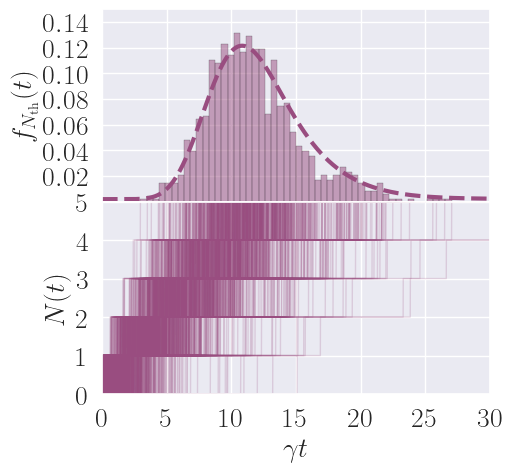

In [87]:
#----------------- Plotting -----------------#

fig = plt.figure(figsize=(5, 5))

color = [0.6, 0.3, 0.5]

plt.subplot(2, 1, 1)
plt.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
plt.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.3)
# plt.vlines(Et, 0, dGt[np.argmin(np.abs(t-Et))], color='k', linestyle='--', linewidth=2, alpha=1)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
plt.yticks(np.arange(0.02, 0.16, 0.02), fontsize=20)
plt.ylim(0.0, 0.15)
plt.xlim(0, tf)
plt.ylabel(r"$f_{N_{\rm th}}(t)$", fontsize=20)


plt.subplot(2, 1, 2)
plt.plot(ts, J.T, color=color, linestyle='-', linewidth=1, alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.ylim(0, N_cutoff)
plt.xlim(0, tf)

plt.xlabel(r'$\gamma t$', fontsize=20)
plt.ylabel(r'$N(t)$', fontsize=20)

plt.subplots_adjust(hspace=0.0)

plt.show()

#----------------- Save -----------------#
fig.savefig('Figures/Garrahan_example.png', bbox_inches='tight', dpi=200)

# Repeat analysis but loop over different values of $\bar{n}$ and $\Omega$ creating a surface plot of the SNR

In [67]:
saved_data = True

# parameters
nbars = [0.1, 0.5, 1]
Omegas = np.linspace(0.0, 3, 100)
gamma = 1

if saved_data:
    # load data
    import pickle 
    # load the dictionary
    with open('Data/data.pickle', 'rb') as handle:
        data = pickle.load(handle)

    # upack data
    Et_vals = data['Et_vals']
    Var_vals = data['Var_vals']
    SNR_vals = data['SNR_vals']
    K_vals = data['K_vals']
    Q_vals = data['Q_vals']
    nbars = data['nbar']
    Omegas = data['Omega']

else:

    # time parameters
    dt = 0.00025
    tf = 100
    t = np.arange(0, tf, dt)

    # Define system operators
    sp = sigmap()
    sm = sigmam()
    sx = sigmax()
    sz = sigmaz()

    # counting params
    nu_k = [0, -1, 0]
    # number of chargers to truncate at 
    Nm = 50
    dN = 1
    N_cutoff = 5
    N = np.arange(-10, Nm, dN)

    # initialise matrices
    Et_vals = np.zeros((len(nbars), len(Omegas)))
    Var_vals = np.zeros((len(nbars), len(Omegas)))
    SNR_vals = np.zeros((len(nbars), len(Omegas)))
    K_vals = np.zeros((len(nbars), len(Omegas)))
    Q_vals = np.zeros((len(nbars), len(Omegas)))

    count = 1

    for i, nbar in enumerate(nbars):
        for j, Omega in enumerate(Omegas):
            
            print('nbar = ', nbar, 'Omega = ', Omega)
            print(count, 'out of', len(nbars)*len(Omegas), 'iterations')
            count += 1
            
            # Define Hamiltonian
            H = Omega*sx

            # define dissipator and Hamiltonian
            c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
            H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

            # steadystate
            rho_ss = steadystate(H, c_ops)

            # Compute dynamical activity per unity time
            K_vals[i, j] = dynamical_activity(nbar, gamma, Omega)
            Q_vals[i, j] = quantum_dynamical_activity(nbar, gamma, Omega)

            # Compute initial state
            rho0 = operator_to_vector(steadystate(H, c_ops))

            #----------------- Solve -----------------#
            proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
            Pn_vec = proj.solve(rho0, nu_k)

            # Compute survival probability
            P0 = np.sum(Pn_vec, axis=0)
            dGt = -np.gradient(P0, dt)

            # Compute mean and variance of distribution
            Et = np.sum(dGt * t)*dt
            Var = np.sum(dGt * t**2 )*dt - Et**2

            SNR = Et**2 / Var

            # Compute mean and variance of distribution
            Et_vals[i, j] = Et
            Var_vals[i, j] = Var

            SNR_vals[i, j] =SNR

In [68]:
# K_vals = np.zeros((len(nbars), len(Omegas)))
# Q_vals = np.zeros((len(nbars), len(Omegas)))

# for i, nbar in enumerate(nbars):
#     for j, Omega in enumerate(Omegas):
#         K_vals[i, j] = dynamical_activity(nbar, gamma, Omega)
#         Q_vals[i, j] = quantum_dynamical_activity(nbar, gamma, Omega)
            

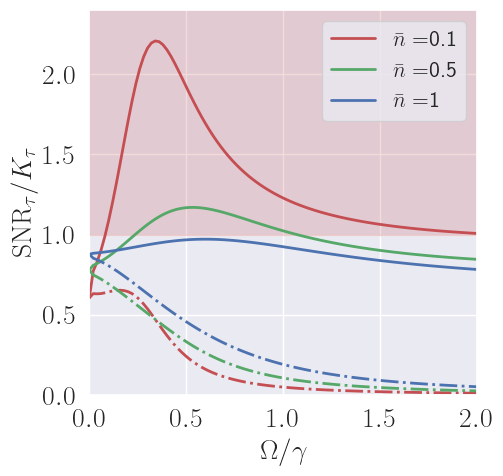

In [86]:
# compute both inequalitys
ineq1 = SNR_vals / (Et_vals*K_vals)
ineq2 = SNR_vals / (Et_vals*(K_vals+Q_vals))

# plot as a function of Omega
fig = plt.figure(figsize=(5, 5))



colors = ['r', 'g', 'b']

for i, nbar in enumerate(nbars):
    plt.plot(Omegas, ineq1[i], '-', color=colors[i], label=r'$\bar{n} = $'+str(nbar), linewidth=2)
    plt.plot(Omegas, ineq2[i], '-.', color=colors[i], linewidth=2)

# plt.hlines(1, 0, Omegas[-1], color='k', linestyle='--', linewidth=2, alpha=1)
plt.fill_betweenx([1, 5], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0, Omegas[-1])
plt.ylim(0, 2.4)

plt.yticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xlabel(r'$\Omega/\gamma$', fontsize=20)
plt.ylabel(r'${\rm SNR}_{\tau}/K_{\tau}  $', rotation=90, fontsize=20)

plt.legend(fontsize=16)

plt.show()

fig.savefig('Figures/inequality.png', bbox_inches='tight', dpi=200)

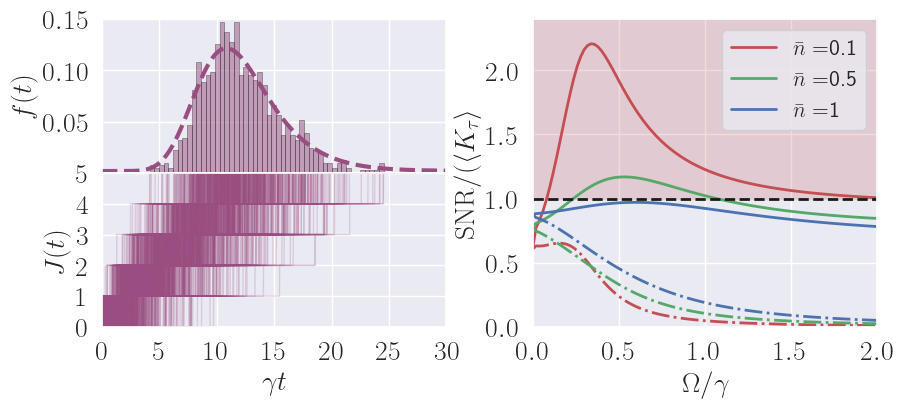

In [53]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
ax1.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.5)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
plt.yticks(np.arange(0.05, 0.2, 0.05), fontsize=20)
ax1.set_ylim(0.0, 0.15)
ax1.set_xlim(0, tf)
ax1.set_ylabel(r'$f(t)$', fontsize=20)

ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(ts, J.T, color=color, linestyle='-', linewidth=1, alpha=0.2)

# ax2.set_xticks(np.arange(0, tf+5, 5))
ax2.set_yticks(np.arange(0, N_cutoff+1, 1))
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.yticks(np.arange(0, N_cutoff+1, 1), fontsize=20)
ax2.set_ylim(0.0, N_cutoff)
ax2.set_xlim(0, tf)
ax2.set_ylabel(r'$J(t)$', fontsize=20)
ax2.set_xlabel(r'$\gamma t$', fontsize=20)

ax3 = fig.add_subplot(gs[:, 1])

colors = ['r', 'g', 'b']

for i, nbar in enumerate(nbars):
    ax3.plot(Omegas, ineq1[i], '-', color=colors[i], label=r'$\bar{n} = $'+str(nbar), linewidth=2)
    ax3.plot(Omegas, ineq2[i], '-.', color=colors[i], linewidth=2)

ax3.hlines(1, 0, Omegas[-1], color='k', linestyle='--', linewidth=2, alpha=1)
plt.fill_betweenx([1, 3], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0, Omegas[-1])
plt.ylim(0, 2.4)

plt.yticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xlabel(r'$\Omega/\gamma$', fontsize=20)
plt.ylabel(r'${\rm SNR}/(\langle K_{\tau} \rangle $', fontsize=20)
plt.legend(fontsize=16)

plt.subplots_adjust(wspace=0.25, hspace=0)

plt.show()

fig.savefig('Figures/Garrahan.png', bbox_inches='tight', dpi=200)
